In [9]:
from __future__ import absolute_import, division

import pkg_resources

from builtins import range, str

from addm_toolbox.ddm import DDMTrial, DDM
from addm_toolbox.util import load_trial_conditions_from_csv

In [53]:
from itertools import product
import pandas as pd
import seaborn as sns

In [46]:
d = .006
sigma = .08
range_d = [0.005, 0.006, 0.007]
rangeD = [0.005, 0.006, 0.007]
range_sigma = [0.065, 0.08, 0.095]
rangeSigma = [0.065, 0.08, 0.095]
trials_file_name = None
trialsFileName=None
trials_per_condition = 100
trialsPerCondition=100 #initially used 800; prob should be >100 for any real fitting
num_threads = 9
numThreads = 9
verbose = False

In [14]:
# Load trial conditions.
if not trialsFileName:
    trialsFileName = pkg_resources.resource_filename(
        u"addm_toolbox", u"test_data/test_trial_conditions.csv")
trialConditions = load_trial_conditions_from_csv(trialsFileName)

# Generate artificial data.
model = DDM(d, sigma)
trials = list()
for (valueLeft, valueRight) in trialConditions:
    for t in range(trialsPerCondition):
        try:
            trials.append(model.simulate_trial(valueLeft, valueRight))
        except:
            print(u"An exception occurred while generating artificial "
                  "trial " + str(t) + u" for condition (" +
                  str(valueLeft) + u", " + str(valueRight) + u").")
            raise

# Get likelihoods for all models and all artificial trials.
numModels = len(rangeD) * len(rangeSigma)
likelihoods = dict()
models = list()
posteriors = dict()
for d in rangeD:
    for sigma in rangeSigma:
        model = DDM(d, sigma)
        if verbose:
            print(u"Computing likelihoods for model " + str(model.params) +
                  u"...")
        try:
            likelihoods[model.params] = model.parallel_get_likelihoods(
                trials, numThreads=numThreads)
        except:
            print(u"An exception occurred during the likelihood "
                  "computations for model " + str(model.params) + u".")
            raise
        models.append(model)
        posteriors[model.params] = 1 / numModels

# Compute the posteriors.
for t in range(len(trials)):
    # Get the denominator for normalizing the posteriors.
    denominator = 0
    for model in models:
        denominator += (posteriors[model.params] *
                        likelihoods[model.params][t])
    if denominator == 0:
        continue

    # Calculate the posteriors after this trial.
    for model in models:
        prior = posteriors[model.params]
        posteriors[model.params] = (likelihoods[model.params][t] *
            prior / denominator)

if verbose:
    for model in models:
        print(u"P" + str(model.params) +  u" = " +
              str(posteriors[model.params]))
    print(u"Sum: " + str(sum(list(posteriors.values()))))

What do the sum of the likelihoods for all 8000 (800 trials per condition for 10 conditions) look like for each parameter combination?

Do the true parameters have the highest likelihood? (d = .006, sigma = .08) No.

In [44]:
dict(zip(likelihoods.keys(), [sum(likelihoods[k]) for k in likelihoods.keys()]))

{(0.005, 0.065): 29.796591224607276,
 (0.005, 0.08): 31.050708342637,
 (0.005, 0.095): 31.287603922682283,
 (0.006, 0.065): 33.238956155061445,
 (0.006, 0.08): 33.79666582116374,
 (0.006, 0.095): 33.464963327458335,
 (0.007, 0.065): 36.08085893898369,
 (0.007, 0.08): 36.07487158582849,
 (0.007, 0.095): 35.28441865582084}

Likelihood surface heatmap

In [56]:
df = pd.DataFrame(list(product(range_d, range_sigma)), columns=['d', 'sigma'])
df['likelihood'] = [sum(likelihoods[k]) for k in likelihoods.keys()]
df = df.pivot(index = 'd', columns = 'sigma', values = 'likelihood')

<AxesSubplot:xlabel='sigma', ylabel='d'>

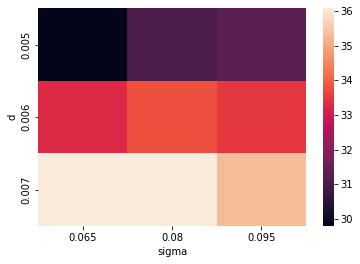

In [57]:
sns.heatmap(df)

What do the posteriors look like?